# Adding Nano Particle

This script computes propagators and concentrations of polymer chains with a nano particle at center.

* Propagators inside of the nano particle is constrained to be zero, e.g., $q({\bf r},s) = 0$.

* Using a mask, $q({\bf r},s+\Delta s)$ inside of the nano particle is set to zero, after computing $\Delta s$ step from $q({\bf r},s)$.

* The mask is a function that
\begin{align}
Mask({\bf r})&=1, \ \ \ \ \textrm{for accessible region} \\
Mask({\bf r})&=0, \ \ \ \ \textrm{for impenetrable region} \\
\end{align}

* This method works only for polymer solution systems.

### 1. Import modules and set environment variables

In [74]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import polymerfts

# OpenMP environment variables
os.environ["MKL_NUM_THREADS"] = "1"  # always 1
os.environ["OMP_STACKSIZE"] = "1G"
os.environ["OMP_MAX_ACTIVE_LEVELS"] = "1"  # 0, 1
os.environ["OMP_NUM_THREADS"] = "2"  # 1 ~ 4

# GPU environment variables
os.environ["LFTS_GPU_NUM_BLOCKS"]  = "256"
os.environ["LFTS_GPU_NUM_THREADS"] = "256"

### 2. Setup some simulation parameters

\begin{align}
N &= 100 \\
\Delta s &= 1/N = 0.01 \\
R_0 & = bN^{1/2} \\
L_x &= 6.0 R_0 \\
L_y &= 6.0 R_0 \\
V &= L_x L_y \\ 
m_x &= 128 \\
m_y &= 128 \\
b_A/b &= 1.0 \\
b_B/b &= 1.0 \\  
\end{align}

In [75]:
# Simulation parameters
nx = [128,128]                 # grid number
lx = [6.0,6.0]                 # box size
ds = 0.01                      # contour step interval
stat_seg_lengths = {"A":1.0}   # statistical segment lengths

### 3. Create a factory

* The factory will create the following instances for chosen platform and data-type.
    * simulation_box
    * molecules
    * propagator_computation_optimizer
    * solver

In [76]:
# Select platform ("cuda" or "cpu-mkl") and data-type ("real" or "complex")
reduce_gpu_memory_usage = False
factory = polymerfts.PlatformSelector.create_factory("cpu-mkl", reduce_gpu_memory_usage, "real")
factory.display_info()

==================== MKL Version ====================
Major version:           2021
Minor version:           0
Update version:          4
Product status:          Product
Build:                   20210904
Platform:                Intel(R) 64 architecture
Processor optimization:  Intel(R) Architecture processors


### 4. A mask indicates the impenetrable region of the nano particle

0.08746337890625 0.08726646259971647


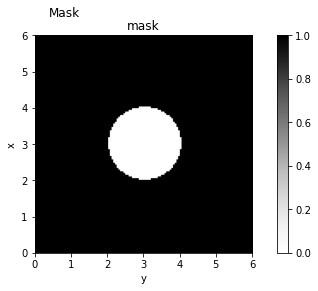

In [77]:
# Set a mask to set q({\bf r},s) = 0$
x = np.linspace(-lx[0]/2, lx[0]/2, num=nx[0], endpoint=False)
y = np.linspace(-lx[1]/2, lx[1]/2, num=nx[1], endpoint=False)

xv, yv = np.meshgrid(x, y, indexing='ij')
nano_particle_radius = 1.0
mask = np.ones(nx)
mask[np.sqrt(xv**2 + yv**2) < nano_particle_radius] = 0.0

# Check 1/V int dr (1-mask(r))
print(1.0-np.mean(mask), (np.pi*nano_particle_radius**2)/np.prod(lx))

# Plot each image with the same vmin and vmax
vmin = mask.min()
vmax = mask.max()

fig, axes = plt.subplots(figsize=(8, 4))
fig.suptitle("Mask")
im = axes.imshow(mask, extent=(0, lx[1], 0, lx[0]), origin="lower", cmap=cm.Greys, vmin=vmin, vmax=vmax)
axes.set(title='mask', xlabel='y', ylabel='x')

fig.subplots_adjust(right=1.0)
fig.colorbar(im)
fig.show()

# Create an instance for computation box
cb = factory.create_computation_box(nx, lx, mask=mask) 
# Create an instance for molecule information with block segment information and chain model ("continuous" or "discrete")
molecules = factory.create_molecules_information("continuous", ds, stat_seg_lengths)

### 5. Add homopolymers

1. In the graph notation, there are two junctions, [0, 1], and there are one block, [[0, 1]].
2. One chain end (node 0) will be initialized with $q_{init}({\bf r};{\textrm G})$.

In [78]:
# Add A homopolymers
molecules.add_polymer(1.0, [["A", 1.0, 0, 1],], {0:"G"})

### 5. Analyze graphs and optimize the computations

Remove the redundant computations and aggregate propagators of multiple side chains.

Reference: [(2025) Dynamic Programming for Chain Propagator Computation of Branched Block Copolymers in Polymer Field Theory Simulations](https://doi.org/10.1021/acs.jctc.5c00103)

In [79]:
# Optimizer to avoid redundant computations
aggregate_propagator_computation = True
propagator_computation_optimizer = factory.create_propagator_computation_optimizer(molecules, aggregate_propagator_computation)
propagator_computation_optimizer.display_blocks()
propagator_computation_optimizer.display_propagators()

--------------- Blocks ---------------
Polymer id, left key:
	aggregated, (left, right) is_junction, (left, right) n_segment, right key, n_repeat, {v, u} list

0, {G}A:
	 X, (X, X), (100, 100), A, 1, {0,1}
--------------- Propagators ---------------
Key:
	height, aggregated, max_n_segment, # dependencies, junction_ends
{G}A:
	 0, X, 100, 0, {}, 
A:
	 0, X, 100, 0, {}, 
Total number of modified diffusion equation steps (time complexity) to compute propagators: 200
Total number of steps after optimizing computation : 200
Computational cost reduction (higher is better) : 0 %


### 7. Set initial conditions and potential fields

1. $q_{init}({\bf r};{\textrm G})$ is set to $\delta(x-1.5R_0)$.

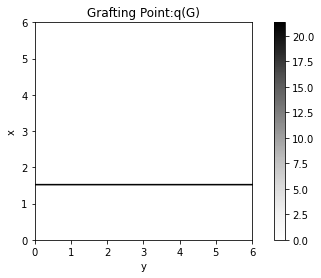

In [80]:
# Set initial conditions for the propagator
q_init = {"G":np.zeros(nx)}
q_init["G"][32,:] = 1.0/(lx[0]/nx[0])

plt.figure(figsize=(8, 4))
plt.title('Grafting Point:q(G)')
plt.xlabel('y')
plt.ylabel('x')
plt.imshow(q_init["G"][:,:], extent=(0, lx[1], 0, lx[0]), origin='lower', cmap=cm.Greys)  # , interpolation='nearest',
plt.colorbar()
plt.show()

# Set potential field
w_A =  np.zeros(nx)
w = {"A": w_A}

### 8. Compute ensemble average concentration (phi) and total partition function (Q)

In [81]:
# Create a solver
solver = factory.create_pseudospectral_solver(cb, molecules, propagator_computation_optimizer)

# Compute Propagators (q) and single partition function (Q)
solver.compute_propagators({"A":w["A"]}, q_init=q_init)

# Single partition function
Q = solver.get_total_partition(0)
print(f"Q:", Q)

# Compute ensemble average concentration (phi)
solver.compute_concentrations()

Q: 0.15222199649140034


### 9. Evolution of Propagators

In [82]:
import matplotlib.animation as animation
from IPython.display import HTML

# Create an animation of the chain propagator (0 → 1)
p,v,u=(0, 0, 1)
fig, ax = plt.subplots(figsize=(8, 4))
fig.suptitle('Chain Propagator $q^{0 → 1}$')
im = ax.imshow(np.reshape(solver.get_chain_propagator(p, v, u, 0), nx)[:,:], extent=(0, lx[1], 0, lx[0]), origin='lower', cmap=cm.Greys) 
fig.colorbar(im, ax=ax)
def update(frame):
    data = np.reshape(solver.get_chain_propagator(p, v, u, frame), nx)[:,:]
    im.set_array(data)
    im.set_clim(vmin=np.min(data), vmax=np.max(data))
    return [im]
anim = animation.FuncAnimation(fig, update, frames=100, interval=1, repeat=False)

# Close the static figure to prevent it from displaying
plt.close(fig)

# Display only the animation
HTML(anim.to_jshtml())

In [83]:
# Create an animation of the chain propagator (1 → 0)
p,v,u=(0, 1, 0)
fig, ax = plt.subplots(figsize=(8, 4))
fig.suptitle('Chain Propagator $q^{1 → 0}$')
im = ax.imshow(np.reshape(solver.get_chain_propagator(p, v, u, 0), nx)[:,:], extent=(0, lx[1], 0, lx[0]), origin='lower', cmap=cm.Greys) 
fig.colorbar(im, ax=ax)
def update(frame):
    data = np.reshape(solver.get_chain_propagator(p, v, u, frame), nx)[:,:]
    im.set_array(data)
    im.set_clim(vmin=0.0, vmax=1.0)
    return [im]
anim = animation.FuncAnimation(fig, update, frames=100, interval=1, repeat=False)

# Close the static figure to prevent it from displaying
plt.close(fig)

# Display only the animation
HTML(anim.to_jshtml())